In [40]:
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')
import pytz
import json 
import random
from datetime import datetime, timedelta
import seaborn as sb
import matplotlib.pyplot as plt
import plotly_express as px
import matplotlib
matplotlib.rcParams['figure.figsize'] = (15.0, 5.0)
import numpy as np
from collections import Counter

In [3]:
file = 'BTC.csv'
data = pd.read_csv(file, parse_dates=['time'], index_col="time",low_memory = False)
data['time'] = data.index

Time at which the number of events reached the maximum  2023-02-06 19:06:23.233071+00:00


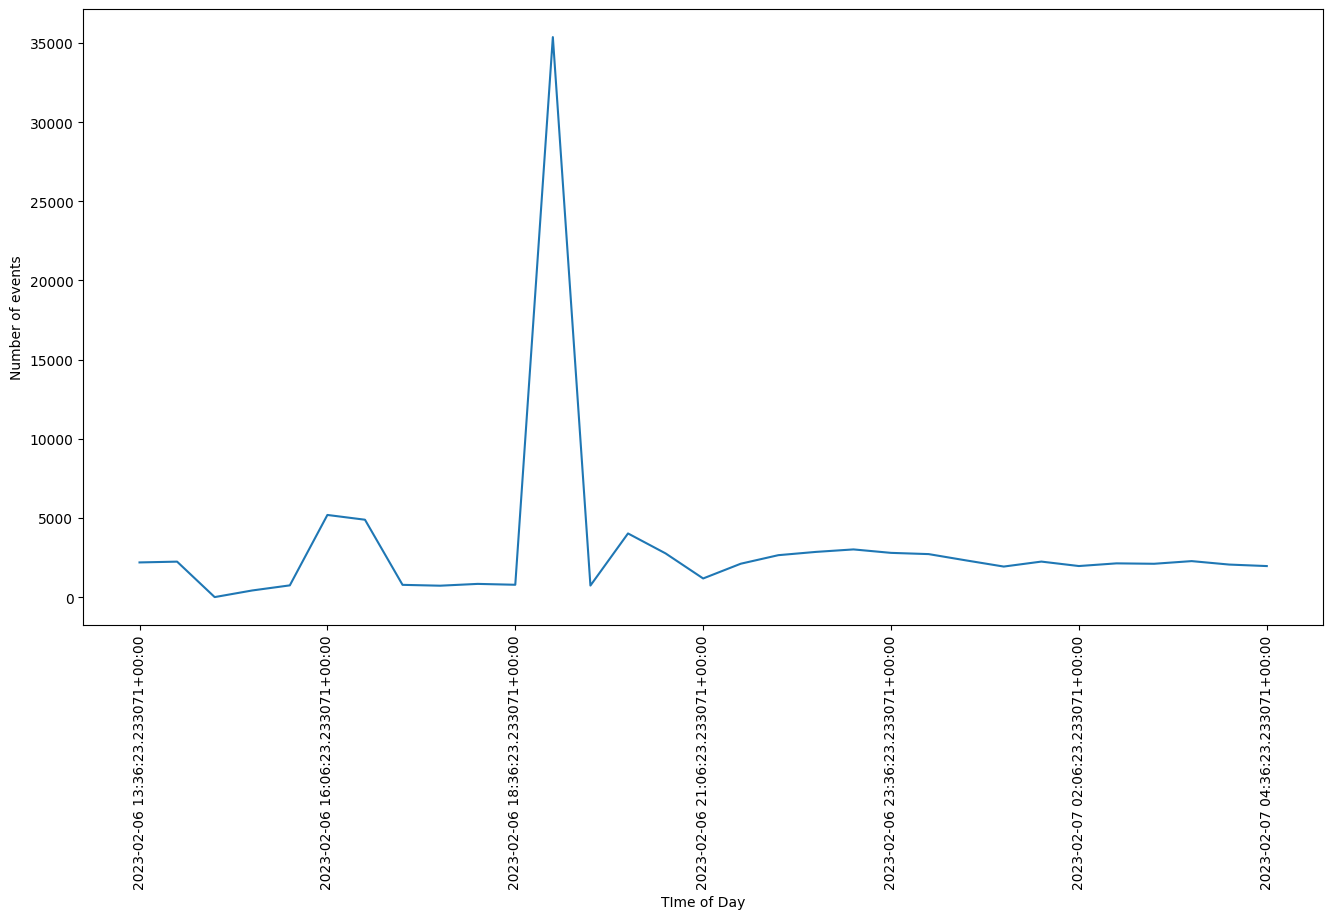

In [42]:
data['time'] = pd.to_datetime(data['time'], unit='ms')
time_intervals = pd.date_range(start = data['time'].min(), end = data['time'].max(), freq='30min')
data['time_interval'] = pd.cut(data['time'], bins = time_intervals, labels= time_intervals[:-1], include_lowest=True)
event_counts = data.groupby('time_interval')['time'].size()
print('Time at which the number of events reached the maximum ', event_counts.idxmax())
event_counts.plot(kind='line', figsize=(16,8))
plt.xlabel('TIme of Day')
plt.xticks(rotation = 'vertical')
plt.ylabel('Number of events')
plt.show()

In [43]:
print("There are {:,} trades".format(data.shape[0]))

There are 100,025 trades


In [44]:
print("There are {:,} orders".format(data.order_id.nunique()))

There are 54,441 orders


In [92]:

# Get the order_ids of canceled orders
canceled_orders = data[(data['type'] == 'done') & (data['reason'] == 'canceled')]

# Get the order_ids that have match messages
matched_order_ids = data[data['type'] == 'match']['order_id']

# Identify flashed orders: canceled orders that have no matches and remaining size > 0
flashed_orders = canceled_orders[~canceled_orders['order_id'].isin(matched_order_ids) & (canceled_orders['remaining_size'] > 0)]

print(f"There are {len(flashed_orders)} flashed orders")


There are 55989 flashed orders


In [89]:
# Get the order_ids of open orders
open_order_ids = data[data['type'] == 'open']['order_id']

# Filter the data to include only the open orders
open_orders_data = data[data['order_id'].isin(open_order_ids)]

# Get the resting orders
resting_orders = open_orders_data[(open_orders_data['type'] == 'open') | 
                                  ((open_orders_data['type'] == 'match') & (open_orders_data['remaining_size'] > 0)) |
                                  ((open_orders_data['type'] == 'done') & (open_orders_data['remaining_size'] > 0))]

print(f"There are {len(resting_orders)} resting orders" ) 

There are 44790 resting orders


In [7]:
imp = ['price', 'remaining_size', 'side', 'type', 'reason', 'order_id', 'time']
data[imp].head(10)


,price,remaining_size,side,type,reason,order_id,time
time,,,,,,,
2023-02-06 13:36:23.233071+00:00,240.0,NaN,buy,received,NaN,92c56a2e-4a12-4c26-b816-6c00dc24567c,2023-02-06 13:36:23.233071+00:00
2023-02-06 13:36:23.233071+00:00,240.0,1.114479,buy,open,NaN,92c56a2e-4a12-4c26-b816-6c00dc24567c,2023-02-06 13:36:23.233071+00:00
2023-02-06 13:36:23.865038+00:00,240.0,NaN,buy,received,NaN,130d7c98-c3dc-41d3-8ab4-a5357f5c23a9,2023-02-06 13:36:23.865038+00:00
2023-02-06 13:36:23.865038+00:00,240.0,1.114479,buy,open,NaN,130d7c98-c3dc-41d3-8ab4-a5357f5c23a9,2023-02-06 13:36:23.865038+00:00
2023-02-06 13:36:25.103053+00:00,240.0,1.114479,buy,done,canceled,130d7c98-c3dc-41d3-8ab4-a5357f5c23a9,2023-02-06 13:36:25.103053+00:00
2023-02-06 13:36:28.467726+00:00,240.0,1.114479,buy,done,canceled,92c56a2e-4a12-4c26-b816-6c00dc24567c,2023-02-06 13:36:28.467726+00:00
2023-02-06 13:36:29.414124+00:00,270.0,NaN,buy,received,NaN,a26ba558-dd03-4d84-877d-200ead9775f5,2023-02-06 13:36:29.414124+00:00
2023-02-06 13:36:29.414124+00:00,270.0,0.990648,buy,open,NaN,a26ba558-dd03-4d84-877d-200ead9775f5,2023-02-06 13:36:29.414124+00:00
2023-02-06 13:36:30.126092+00:00,270.0,NaN,buy,received,NaN,46cb6155-ed7e-4fc5-b87d-8b80204fbbc7,2023-02-06 13:36:30.126092+00:00


In [8]:
import numpy as np
dt = data.time.diff().iloc[1:].dt
dt = dt.seconds.astype(float) + dt.microseconds*1e-6
dt*=1000

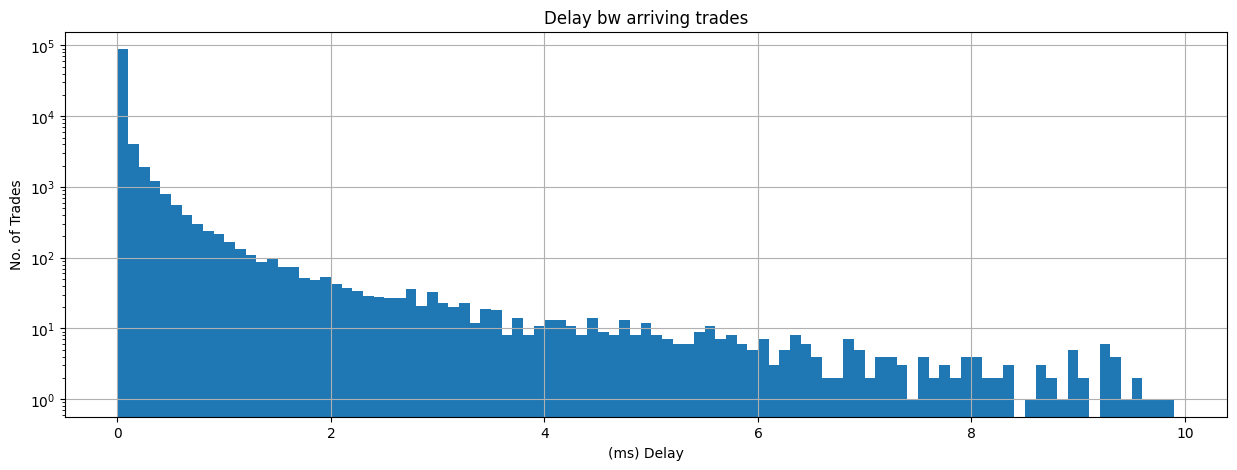

In [9]:
import numpy as np
import matplotlib.pyplot as plt
bins = np.arange(0, 10, 0.1)
dt.sort_values().diff().hist(bins=bins)  
plt.xlabel("(ms) Delay")
plt.ylabel("No. of Trades")
plt.yscale('log')
plt.title("Delay bw arriving trades")
plt.show()

In [10]:
print( "Minimum non zero number of milliseconds: ", dt[dt>0].min())

Minimum non zero number of milliseconds:  0.028


In [11]:
data[data.order_id=='130d7c98-c3dc-41d3-8ab4-a5357f5c23a9'][imp+['order_type']]

,price,remaining_size,side,type,reason,order_id,time,order_type
time,,,,,,,,
2023-02-06 13:36:23.865038+00:00,240.0,NaN,buy,received,NaN,130d7c98-c3dc-41d3-8ab4-a5357f5c23a9,2023-02-06 13:36:23.865038+00:00,limit
2023-02-06 13:36:23.865038+00:00,240.0,1.114479,buy,open,NaN,130d7c98-c3dc-41d3-8ab4-a5357f5c23a9,2023-02-06 13:36:23.865038+00:00,NaN
2023-02-06 13:36:25.103053+00:00,240.0,1.114479,buy,done,canceled,130d7c98-c3dc-41d3-8ab4-a5357f5c23a9,2023-02-06 13:36:25.103053+00:00,NaN
